Starting grid search for hyperparameters
Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\okola\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Grid search completed.
Best hyperparameters found:
{'alpha': 0.001, 'kernel': 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05), 'n_restarts_optimizer': 20}
R-squared (Train): 0.975163
R-squared (Test): 0.885331


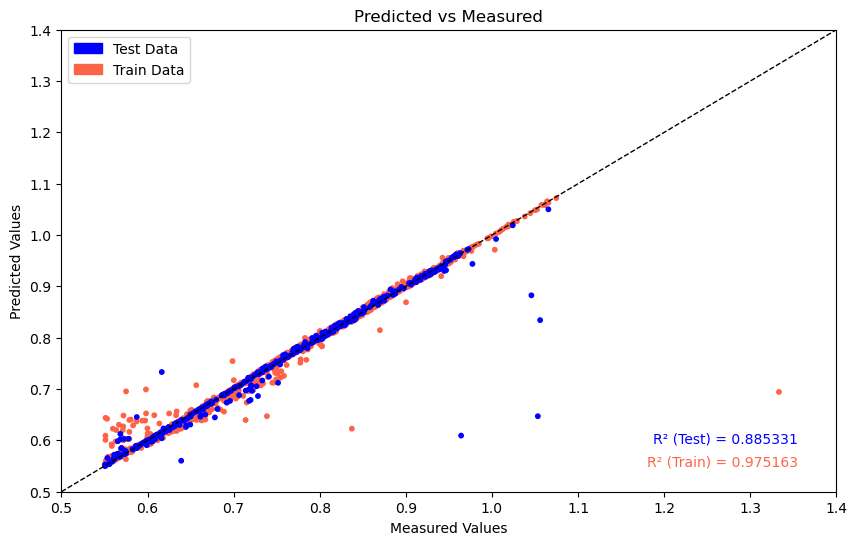

In [3]:
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches

# Load your data 
data = pd.read_csv('df_for_models.csv')

# Select relevant features and target variable
selected_features = ['Corrected Tpr', 'Corrected Ppr']
target_variable = 'z'
X = data[selected_features]
y = data[target_variable]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the parameters grid
param_grid = {
    "kernel": [C(1.0, (1e-1, 1e1)) * RBF(1.0, (1e-1, 1e1)) + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))],
    "n_restarts_optimizer": [10, 20],
    "alpha": [1e-10, 1e-5, 1e-3],
}

# Initialize GPR with default parameters
gpr = GaussianProcessRegressor(random_state=42)

print("Starting grid search for hyperparameters")
# Initialize GridSearchCV
grid_search = GridSearchCV(gpr, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2', verbose=1)

# Fit the model to the training data with grid search for hyperparameters
grid_search.fit(X_train, y_train)

print("Grid search completed.")
print("Best hyperparameters found:")
print(grid_search.best_params_)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set and training set
y_pred_test = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

# Calculate R-squared for evaluation
r2_test = r2_score(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)

print(f"R-squared (Train): {r2_train:.6f}")
print(f"R-squared (Test): {r2_test:.6f}")

# Plotting (unchanged)
fig, ax = plt.subplots(figsize=(10, 6))

# set the limits of x-axis and y-axis from 0.5 to 1.5
ax.set_xlim(0.5, 1.4)
ax.set_ylim(0.5, 1.4)


predicted_colors_train = ['tomato' if pred >= actual else 'tomato' for pred, actual in zip(y_pred_train, y_train)]
pred_actual_scatter_train = ax.scatter(y_train, y_pred_train, c=predicted_colors_train, marker=".", s=40, label='Train Data')

predicted_colors_test = ['blue' if pred >= actual else 'blue' for pred, actual in zip(y_pred_test, y_test)]
pred_actual_scatter_test = ax.scatter(y_test, y_pred_test, c=predicted_colors_test, marker=".", s=40)

ax.plot([0.5, 1.4], [0.5, 1.4], color='black', linestyle='--', lw=1, label='Line of Equality')

overprediction_patch = mpatches.Patch(color='blue', label='Test Data')
underprediction_train_patch = mpatches.Patch(color='tomato', label='Train Data')

ax.text(0.95, 0.05, f'R\u00b2 (Train) = {r2_train:.6f}', transform=ax.transAxes,
        fontsize=10, color='tomato', ha='right', va='bottom')
ax.text(0.95, 0.1, f'R\u00b2 (Test) = {r2_test:.6f}', transform=ax.transAxes,
        fontsize=10, color='blue', ha='right', va='bottom')

legend_elements = [
    overprediction_patch,
    underprediction_train_patch,
]

ax.set_title('Predicted vs Measured')
ax.set_xlabel('Measured Values')
ax.set_ylabel('Predicted Values')

plt.legend(handles=legend_elements)

plt.show()


In [4]:
# Create DataFrame for training data
train_results = pd.DataFrame({
    'Data Type': 'Train',
    'Actual z': y_train,
    'Predicted z': y_pred_train
})

# Create DataFrame for testing data
test_results = pd.DataFrame({
    'Data Type': 'Test',
    'Actual z': y_test,
    'Predicted z': y_pred_test
})

# Concatenate the training and testing data
model_results = pd.concat([train_results, test_results], ignore_index=True)

# Export the DataFrame to an Excel file
model_results.to_excel(" GPR corrected Pseudo data results.xlsx", index=False)


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Calculate evaluation metrics for test data
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

# Calculate evaluation metrics for train data
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

# Print the evaluation metrics for test data
print("Evaluation Metrics for Test Data:")
print(f'Mean Absolute Error (MAE): {mae_test:.9f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_test:.9f}%')
print(f'Root Mean Squared Error (RMSE): {rmse_test:.9f}')
print(f'R\u00b2 Value: {r2_test:.9f}')

# Print the evaluation metrics for train data
print("\nEvaluation Metrics for Train Data:")
print(f'Mean Absolute Error (MAE): {mae_train:.9f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_train:.9f}%')
print(f'Root Mean Squared Error (RMSE): {rmse_train:.9f}')
print(f'R\u00b2 Value: {r2_train:.9f}')


In [ ]:
from sklearn.svm import NuSVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Calculate residuals for the training data
residuals_train = ((y_pred_train - y_train) / y_train) * 100


# Calculate residuals for the testing data
residuals_test = ((y_pred_test - y_test) / y_test) * 100

# Separate residuals into overprediction and underprediction categories for the training data
over_prediction_train = y_pred_train[residuals_train > 0]
under_prediction_train = y_pred_train[residuals_train <= 0]

# Separate residuals into overprediction and underprediction categories for the testing data
over_prediction_test = y_pred_test[residuals_test > 0]
under_prediction_test = y_pred_test[residuals_test <= 0]

# Plotting residuals for both training and testing data
plt.figure(figsize=(10, 6))

# Plotting overpredictions in green and underpredictions in red for the training data
plt.scatter(over_prediction_train, residuals_train[residuals_train > 0], c='tomato', marker='o', edgecolor='black', alpha=0.7, label='Train Relative Percentage Errors')
plt.scatter(under_prediction_train, residuals_train[residuals_train <= 0], c='tomato', marker='o', edgecolor='black', alpha=0.7)

# Plotting overpredictions in blue and underpredictions in orange for the testing data
plt.scatter(over_prediction_test, residuals_test[residuals_test > 0], c='blue', marker='o', edgecolor='black', alpha=0.7, label='Test Relative Percentage Errors')
plt.scatter(under_prediction_test, residuals_test[residuals_test <= 0], c='blue', marker='o', edgecolor='black', alpha=0.7)

plt.xlabel('Predicted Values')
plt.ylabel('Percentage Relative Errors')
plt.title('Percentage Relative Errors of GPR Model')

# Adding a horizontal line at y=0
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)

# Show legends
plt.legend()

# Show the plot
plt.show()
